# A first example of a numerical simulation

In this exercise, you will conduct a first instance of numerical simulation of the time evolution of a system. We will solve an advection equation of the form

$$\frac{\partial u}{\partial t} + a \frac{\partial u}{\partial x} = 0  \tag{1}$$

with $a$ being a __constant__. In subsequent exercises, more general cases will be considered, with $a$ no longer constant.

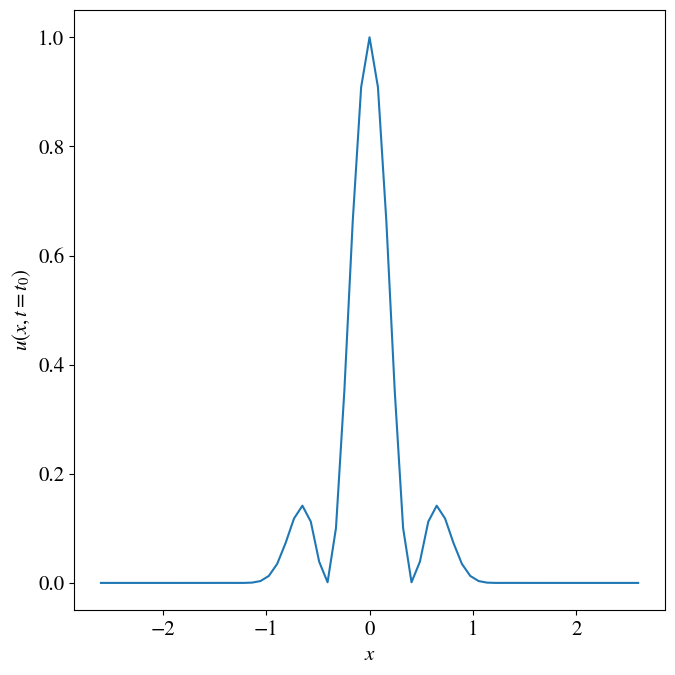

In [1]:
import numpy as np
import matplotlib.pyplot as plt
from nm_lib import nm_lib as nm
from importlib import reload
reload(nm);
# Define some simple global matplotlib settings
plt.rcParams.update(
    {"font.size" : "15",
     "font.family"          : "STIXGeneral",
     "mathtext.fontset"     : "stix",
     "figure.autolayout"    : "True",
     "figure.figsize"       : (7,7),
     "lines.markersize"     : 10,
     }
)

def get_uu_t0(xx: np.ndarray) -> np.ndarray:
    nom = np.cos(6*np.pi*xx/5)**2
    den = np.cosh(5*xx**2)
    return nom/den

if __name__ == "__main__":
    _x0 = -2.6
    _xf = 2.6
    _nint = int(64)
    _xx, _dx = nm.get_xx(_nint, _x0, _xf)
    _uu_t0 = get_uu_t0(_xx)
    fig, ax = plt.subplots()
    ax.plot(_xx, _uu_t0)
    ax.set_ylabel("$u(x,t=t_0)$")
    ax.set_xlabel("$x$");

## 1 – The $a = const$ case: the mathematical problem

We would like to solve equation (1) numerically for $x  [x_0, x_f]$ with $x_0 = −2.6$, $x_f = 2.6$, periodic boundary conditions and with the initial condition:

$$u(x,t=t_0) = \cos^2 \left(\frac{6 \pi x}{5} \right) / \cosh(5x^2) \tag{2}$$

We start by representing that function in the given interval.

## 2 – Spatial derivative.

We discretize the initial condition by subdividing the spatial domain into $nint=64$ equal intervals. The function will therefore be sampled with $nump=65$ points, namely $(u_0, u_1, u_2, ... , u_{nump−1})$ at equidistant values of the abscissa, $(x_0, x_1, x_2, ..., x_{nump−1})$. Let us calculate the spatial derivative of the function through non-centered finite differences of the form:

$$\left(\frac{\partial u}{\partial x}\right)_{x=x_i} \rightarrow \frac{u_{i+1}-u_{i}}{\Delta x}  \tag{3}$$

On the basis of the experience gained with the previous batch of exercises (ex. 1), which order of approximation can we expect now for the calculation of the derivative since we are using non-centered finite differences?

### Solution
The finite difference on this form is the upwind differencing, which we now know is of 2nd order _if evaluated on half integer grid points_. For non-centered upwind the approximation is of first order. I can test this using `order_conv` from `nm_lib`, which results in a mean order of convergence $\sim1$ (again, I haven't figured out why the result of `order_conv` is negative, but I interpret the result as positiv.). For completeness I test with the 2nd and 4th order _central_ differencing, which also gives the expected result of $\sim 2$ and $\sim 4$.

/Users/jakobs/Documents/phd/courses/AST9110/nm_lib/nm_lib/nm_lib.py:52: RuntimeWarning: invalid value encountered in divide
  return np.ma.log2((hh4[::4]-hh2[::2])/(hh2[::2]-hh))


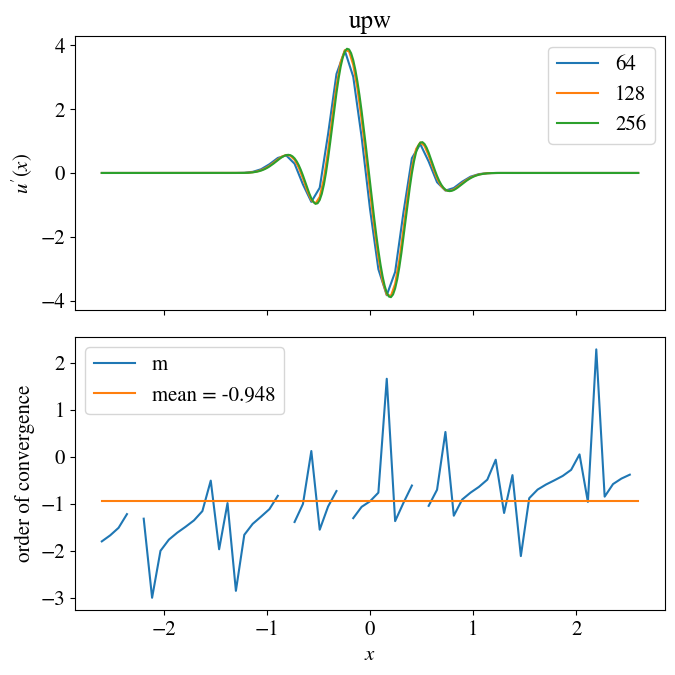

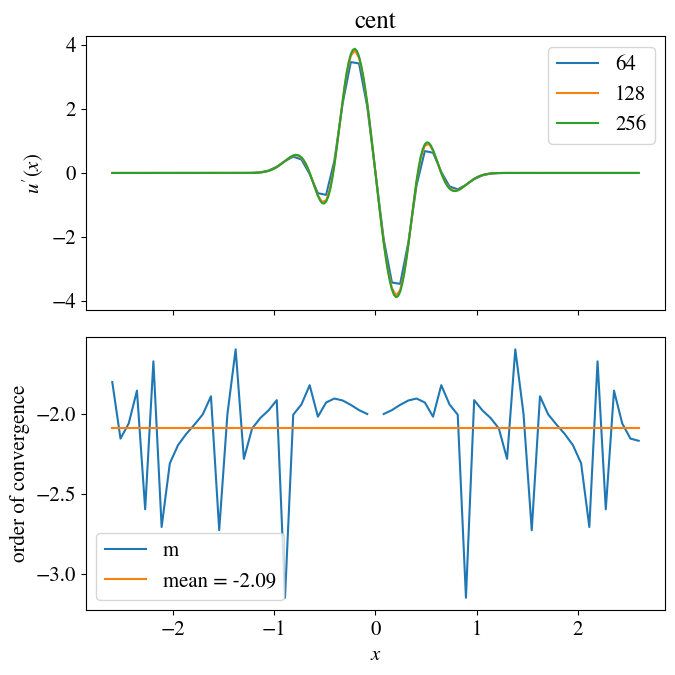

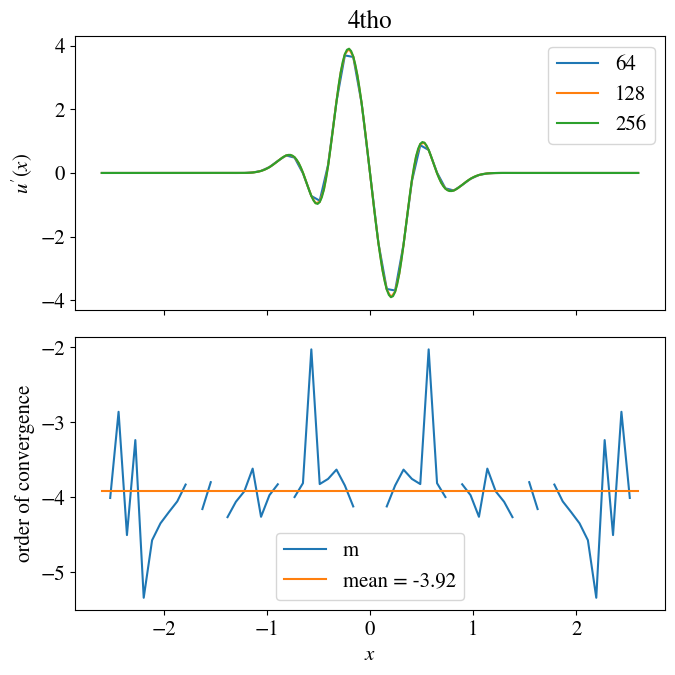

In [2]:
def get_order_spatial(min_nint: int, deriv_type: str = "upw", u_of_x: callable = get_uu_t0, x0=-2.6, xf=2.6, plot: bool = True) -> np.ndarray:
    if deriv_type == "upw":
        ddx = lambda xx, uu: nm.deriv_upw(xx, uu, method="roll")
    elif deriv_type == "dnw":
        ddx = lambda xx, uu: nm.deriv_dnw(xx, uu, method="roll")
    elif deriv_type == "cent":
        ddx = lambda xx, uu: nm.deriv_cent(xx, uu, method="roll")
    elif deriv_type == "4tho":
        ddx = lambda xx, uu: nm.deriv_4tho(xx, uu, method="roll")
    else:
        print("Found no fitting deriv type")
        return None
    nints = [min_nint, 2*min_nint, 4*min_nint]
    dudx_list = []
    fig, ax = plt.subplots(nrows=2, sharex=True) if plot else (None, None)
    for nint in nints:
        xx, _ = nm.get_xx(nint, x0, xf)
        uu = u_of_x(xx)
        dudx_list.append(ddx(xx, uu))
        if plot:
            ax[0].set_title(deriv_type)
            ax[0].plot(xx, dudx_list[-1],label=f"{nint:d}")
    m = nm.order_conv(*dudx_list)
    mmean = np.nanmean(m)
    if plot:
        xx, _ = nm.get_xx(min_nint, x0, xf)
        ax[0].legend()
        ax[0].set_ylabel("$u'(x)$")
        ax[1].plot(xx, m, label="m")
        ax[1].plot(xx, mmean*np.ones_like(xx), label=f"mean = {mmean:.3g}")
        ax[1].legend()
        ax[1].set_xlabel("$x$")
        ax[1].set_ylabel("order of convergence")
    return m

if __name__ == "__main__":
    get_order_spatial(_nint,"upw")
    get_order_spatial(_nint,"cent")
    get_order_spatial(_nint,"4tho")


## 3 – Time advance.

We want to calculate an approximation to the value of the function at times later than $t = t_0$, for instance, at time $t_0 + \Delta t$. To that end, we carry out a discretization of the time axis, calculating approximate values for the time derivative as follows:

$$\left(\frac{\partial u}{\partial t}\right)_{\underset{t=t_0}{x=x_i}} \rightarrow \frac{u_i(t_0 + \Delta t)-u_i(t_0)}{\Delta t}\tag{4}$$

Using now the differential equation (1) and expression (3), we can calculate an approximate value for the function $u$ at $x_i$ and time $t_0 + \Delta t$ as follows:

$$u_i(t_0+\Delta t) = u_i(t_0) - a \frac{u_{i+1}(t_0) - u_i(t_0)}{\Delta x}\Delta t  \tag{5}$$

Using (5), calculate $u_i$ at time $t_0 + \Delta t$ at all points of the sample excluding the rightmost point (i.e., excluding $x_{nump−1}$). Use  $\Delta t = 0.98 \Delta x/|a|$ and a = −1. Fill in `nm_lib` the functions `step_adv_burgers` and `cfl_adv_burger`. 

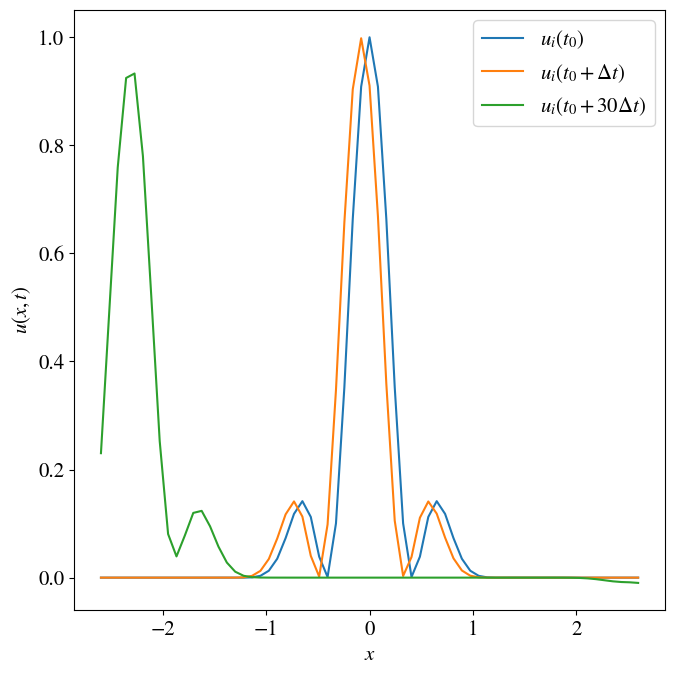

In [9]:
if __name__ == "__main__":
    a = -1
    xx, _ = nm.get_xx(_nint, _x0, _xf)
    uu_t0_i = get_uu_t0(xx)
    dt, uu_step = nm.step_adv_burgers(xx, uu_t0_i, a)
    uu_t0_1 = uu_t0_i - a * uu_step * dt
    uu_t0 = uu_t0_i
    nt = 30
    for i in range(1, nt):
        dt, uu_step = nm.step_adv_burgers(xx, uu_t0, a)
        uu_t1 = uu_t0 + uu_step * dt
        uu_t0 = uu_t1

    fig, ax = plt.subplots()
    ax.plot(xx, uu_t0_i, label="$u_i(t_0)$")
    ax.plot(xx, uu_t0_1, label="$u_i(t_0 + \Delta t)$")
    ax.plot(xx, uu_t1, label=f"$u_i(t_0 + {nt:d}\Delta t)$")
    ax.legend()
    ax.set_ylabel("$u(x,t)$")
    ax.set_xlabel("$x$")

## 4 – The boundaries.

To calculate the function at the rightmost point of the interval, we use a periodicity condition on $u$: $u_{nump−1}(t_0 + \Delta t) = u_0(t_0 + \Delta t)$. Consider cutting the ill-calculated (or missing) grid points and using `NumPy.pad` to add different boundary conditions. Use `wrap`

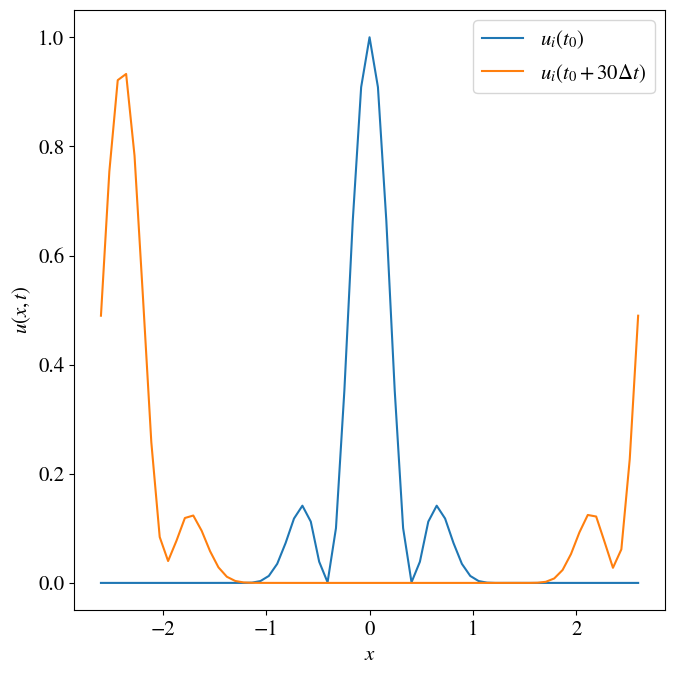

In [4]:
if __name__ == "__main__":
    a = -1
    xx, _ = nm.get_xx(_nint, _x0, _xf)
    uu_t0_i = get_uu_t0(xx)
    uu_t0 = uu_t0_i
    nt = 30
    for i in range(nt):
        # Passing bnd_limits to step_adv_burgers:
        dt, uu_step = nm.step_adv_burgers(xx, uu_t0, a, ddx = lambda x,u:nm.deriv_upw(x,u,method="roll"), bnd_limits=[0,1])
        uu_t1 = uu_t0 + uu_step * dt
        uu_t0 = uu_t1

    fig, ax = plt.subplots()
    ax.plot(xx, uu_t0_i, label="$u_i(t_0)$")
    ax.plot(xx, uu_t1, label=f"$u_i(t_0 + {nt:d}\Delta t)$")
    ax.legend()
    ax.set_ylabel("$u(x,t)$")
    ax.set_xlabel("$x$")

## 5 – Subsequent steps in time.

Having calculated the values $u_i$, $i = 0, 1, 2, ...,nump−1,$ at time $t_0+\Delta t$, we can carry out another step in time of size $\Delta t$, following exactly the method just explained. In general, if we have calculated the value of the $u$ function at $x_i$ and time $n\Delta t$, which we will call $u^n_i$, we can carry out the next step in time, of size $\Delta t$, through the expression:

$$u_i^{n+1} = u_i^n - a \frac{u_{i+1}^n - u_i^n}{\Delta x}\Delta t  \tag{6}$$

Periodic boundary conditions must be applied, as explained in 4 above, to finish the calculation at each timestep. Fill in nm_lib the function `evolv_adv_burgers`. 

Carry out many steps in time so you can clearly understand the mathematical nature of the solution of the equation. For example, in Python, you can _matplotlib.animation_ to see the evolution. 

In [5]:
reload(nm)
nt = 60
xx, _ = nm.get_xx(64, -2.6, 2.6)
u0 = get_uu_t0(xx)
t, ut = nm.evolv_adv_burgers(xx, u0, nt, a=-1,
                               ddx = lambda x,y: nm.deriv_upw(x,y, method="roll"))
ut = ut.T

if __name__ == "__main__":
    from matplotlib import animation
    from matplotlib.animation import FuncAnimation
    from IPython.display import HTML

    fig, axes = plt.subplots(nrows=1, ncols=1, figsize=(10, 5))

    def init(): 
        axes.plot(xx,ut[:,0])

    def animate(i):
        axes.clear()
        axes.plot(xx,ut[:,i])
        axes.set_title('t=%.2f'%t[i])
        
    anim = FuncAnimation(fig, animate, interval=10, frames=nt, init_func=init)
    html = HTML(anim.to_jshtml())
    display(html)
    plt.close()

## 6 – Comparison with the exact solution.

Through one of the theory sessions, we know the exact solution of eq. (1) for the initial condition (2). Draw the exact solution on top of the numerical one using a dashed line. Then, explain the mathematical behavior of the solution. __Important note__: consider that the initial condition is eq (2) in $[x_0, x_f]$, _with periodic conditions at the boundaries_. In other words, the initial condition consists of an infinite repetition of the function (2) you represented between $[x_0, x_f]$ next to each other. Use this fact when comparing your numerical solution with the analytical one. __Hint__: if you consider points starting within the interval $(x_0, x_f)$ and moving with speed $a$, they will go outside the domain after some time. Use mod operator (\% in Python) to bring them back into the domain respecting the periodicity of the problem or _numpy.pad_ to pad ghost points, i.e., points out of the numerical domain, which will allow defining the boundaries, at both ends of the numerical domain. NumPy.pad allows various types of boundaries.

In [10]:
reload(nm)
def get_u_exact(xx,t,a):
    xmin = xx[0]
    xmax = xx[-1]
    x_positiv = xx - xmin
    y = (x_positiv-a*t)%(xmax-xmin) + xmin
    return get_uu_t0(y)

if __name__ == "__main__":
    nint = 64
    nt = 60
    a = -1
    x0 = -2.6
    xf = 2.6
    xx, _ = nm.get_xx(nint, x0, xf)
    uu_t0 = get_uu_t0(xx)
    tt, uunt = nm.evolv_adv_burgers(xx, uu_t0, nt, a, ddx = lambda x,u:nm.deriv_upw(x,u,method="roll"), bnd_limits=[0,1])

    fig, ax = plt.subplots(nrows=1, ncols=1, figsize=(10, 5))

    def init(): 
        ax.plot(xx,uunt.T[:,0])

    def animate(i):
        ax.clear()
        ax.plot(xx,uunt.T[:,i], label="uunt")
        ax.plot(xx, get_u_exact(xx, tt[i],a),ls="--", label="exact")
        ax.set_title('t=%.2f'%tt[i])
        ax.legend(loc=1)
            
    anim = FuncAnimation(fig, animate, interval=100, frames=nt, init_func=init)
    html = HTML(anim.to_jshtml())
    display(html)
    plt.close()



Add a CI/CD pipeline to run this test and validate each push commit. This lets us know if a specific submitted change damages the existing code. For this, fill in ./github/workflows/test.yml

## Get back to this pipeline

## 7 – Resolution increase in space and time. 

Let us repeat the calculation of the previous paragraphs, increasing the number of space intervals by factors of 2. Check if the numerical solution gets increasingly close to the analytical solution. Important: the comparison must be made _for the same values of $x$ and $t$ for all resolutions you check_. Choose a fixed time when the traveling function has already gone through the whole domain a few times. 

In [7]:
if __name__ == "__main__":
    check_time = 50
    nr_increases = 4    # number of times increasing space resolution
    b2s = 6     # start number of intervals in base 2
    nints = np.logspace(b2s,b2s+nr_increases,nr_increases+1,base=2, dtype=int)
    x0 = -2.6
    xf = 2.6
    a = -1
    maxabserr = np.zeros(len(nints))
    for i,nint in enumerate(nints):
        xx, dx = nm.get_xx(nint, x0, xf)
        nt = int(100/dx[1])
        uu_t0 = get_uu_t0(xx)
        tt, uunt = nm.evolv_adv_burgers(xx, uu_t0,nt=nt,a=a,ddx = lambda x,u: nm.deriv_upw(x,u,method="roll"), bnd_limits=[0,1])
        id_time_check = np.argmin(np.abs(tt-check_time))
        u_exact_check = get_u_exact(xx,tt[id_time_check],a)
        maxabserr[i] = np.max(np.abs(uunt[id_time_check]-u_exact_check))

Text(0.5, 1.0, 't=50.00')

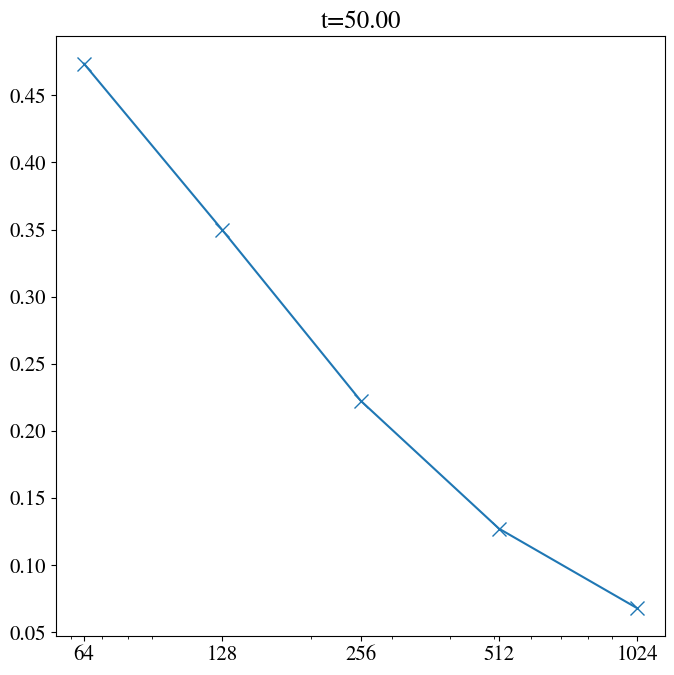

In [8]:
fig, ax = plt.subplots()
ax.semilogx(nints, maxabserr,"-x")
ax.set_xticks(nints, [f"{val:d}" for val in nints])
ax.set_title(f"t={tt[id_time_check]:.2f}")